In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

sns.set_context("talk")
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d

from src.load_data import load_data
from ZilongCode.utils import (
    bandpassfilter,
    get_zero_phase,
    get_steps,
    get_diffusion_exponent,
)

### 1, load example data and decoder

In [3]:
epoch_key = ("bon", 8, 4)

data = load_data(epoch_key)

Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [4]:
datafolder = (
    "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ThetaSweepTrajectories"
)

animal, day, epoch = epoch_key
# load the classifier results
cv_classifier_clusterless_results = xr.open_dataset(
    os.path.join(
        datafolder,
        f"{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc",
    )
)

# get all time slice
t = data["position_info"].index / np.timedelta64(1, "s")

In [34]:
epoch_key = ("bon", 3, 4)

datafolder = (
    "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ThetaSweepTrajectories"
)

animal, day, epoch = epoch_key
# load the classifier results
cv_classifier_clusterless_results = xr.open_dataset(
    os.path.join(
        datafolder,
        f"{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc",
    )
)

ahead_behind_dist = cv_classifier_clusterless_results[
    "mental_distance_from_actual_position_ahead_behind"
]

# calculate the percentage of ahead and behind
np.mean(ahead_behind_dist)

<xarray.DataArray 'mental_distance_from_actual_position_ahead_behind' ()>
array(-12.87925998)

### 2, plot the decoded trajectory and zoom in to show the details on the first row

In [7]:
def plot_decoded_trajectory(
    time_slice, time_slice_sweep, time_slice_replay, t, results, data
):

    """
    Modified from https://github.com/edeno/replicate_kenny_analysis/blob/master/notebooks/Bond_day8_Epoch4.ipynb
    by Zilong, 30/08/2023
    plor the theta sweeps in time_slice
    Input:
        time_slice: the time slice to plot
        t: the time index
        results: the results from the model
        data: the data from the model
        add_zero_phase_index: whether to add the zero phase index
    Output:
        a plot with 3 subplots
    """

    cmap = plt.cm.inferno
    cmap.set_bad("white", alpha=1.0)
    labelsize = 10
    ticksize = 8
    # set background color to white
    sns.set_style("white")

    fig = plt.figure(figsize=(8, 3), dpi=300)

    gs = gridspec.GridSpec(2, 3, width_ratios=[3, 1, 1], height_ratios=[3, 1])

    ax1 = plt.subplot(gs[0, 0])

    # ax 1
    results["acausal_posterior"].sum("state", skipna=False).sel(time=time_slice).plot(
        x="time",
        y="position",
        robust=True,
        ax=ax1,
        cmap=cmap,
        vmin=0.0,
    )

    arm_min_max = (
        data["position_info"]
        .groupby("arm_name")
        .linear_position.aggregate(["min", "max"])
    )
    max_time = results.sel(time=time_slice).time.max() + 0.01
    ax1.text(
        max_time,
        arm_min_max.loc["Center Arm", "min"],
        "C",
        ha="left",
        va="bottom",
        weight="bold",
        fontsize=labelsize,
    )
    ax1.text(
        max_time,
        arm_min_max.loc["Center Arm", "max"],
        "*",
        ha="left",
        va="top",
        weight="bold",
        fontsize=labelsize,
    )
    ax1.text(
        max_time,
        arm_min_max.loc["Right Arm", "max"],
        "R",
        ha="left",
        va="top",
        weight="bold",
        fontsize=labelsize,
    )
    ax1.text(
        max_time,
        arm_min_max.loc["Right Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
        fontsize=labelsize,
    )

    ax1.text(
        max_time,
        arm_min_max.loc["Left Arm", "max"],
        "L",
        ha="left",
        va="top",
        weight="bold",
        fontsize=labelsize,
    )

    ax1.text(
        max_time,
        arm_min_max.loc["Left Arm", "min"],
        "*",
        ha="left",
        va="center",
        weight="bold",
        fontsize=labelsize,
    )

    ax1.set_ylabel("Position \n [cm]")

    ax1.plot(
        data["position_info"].reset_index().set_index(t).loc[time_slice].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice]
        .linear_position,
        color="darkturquoise",
        linestyle="-",
        linewidth=0.5,
        alpha=1,
    )

    ax1.set_xlabel("")
    ax1.set_xticks([])
    # remove coorbar and space it consumes
    ax1.collections[0].colorbar.remove()

    # ax 2
    ax2 = plt.subplot(gs[1, 0])

    results.mental_distance_from_actual_position.sel(time=time_slice).plot(
        x="time", ax=ax2, color="#F18D00", linewidth=0.2, alpha=0.5
    )
    # set y label as 'Offset' x label as 'Time (seconds)'
    ax2.set_ylabel("Offset \n [cm]", fontsize=labelsize)
    ax2.set_xlabel("Time (seconds)", fontsize=labelsize)

    # add xticks 5 numbers from time_slice.start to time_slice.stop
    ax2.set_xticks(np.linspace(time_slice.start, time_slice.stop, 5))
    # set x lim
    ax2.set_xlim(time_slice.start, time_slice.stop)

    # algin the y labels of all subplots
    fig.align_ylabels([ax1, ax2])

    # add ripple times to the plot as red bars on top of the LFP
    # first get the ripples time within the time slice
    for i in data["ripple_times"].index:
        # get the ripple time
        ripple_time = data["ripple_times"].iloc[i - 1]
        start_time = ripple_time.loc["start_time"] / np.timedelta64(1, "s")
        end_time = ripple_time.loc["end_time"] / np.timedelta64(1, "s")
        # if start_time and end_time are both in the time slice. then add the ripple to the plot
        if start_time > time_slice.start and end_time < time_slice.stop:
            ax1.axvspan(start_time, end_time, color="grey", alpha=0.6, lw=0.1)
            ax2.axvspan(start_time, end_time, color="grey", alpha=0.6, lw=0.1)

    # ax 3
    ax3 = plt.subplot(gs[0, 1])
    # plot
    results["acausal_posterior"].sum("state", skipna=False).sel(
        time=time_slice_sweep
    ).plot(
        x="time",
        y="position",
        robust=True,
        ax=ax3,
        cmap=cmap,
        vmin=0.0,
    )

    ax3.plot(
        data["position_info"].reset_index().set_index(t).loc[time_slice_sweep].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice_sweep]
        .linear_position,
        color="darkturquoise",
        linestyle="-",
        linewidth=2,
        alpha=1,
    )

    # remove all labels, ticks and spines in axi, as well as colorbars
    ax3.set_xlabel("")
    ax3.set_ylabel("")
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.spines["left"].set_visible(False)
    ax3.spines["bottom"].set_visible(False)
    ax3.collections[0].colorbar.remove()
    # add title
    ax3.set_title("Theta Sweep", fontsize=labelsize)

    # ax4
    ax4 = plt.subplot(gs[1, 1])
    results.mental_distance_from_actual_position.sel(time=time_slice_sweep).plot(
        x="time", ax=ax4, color="#F18D00", linewidth=1, alpha=0.8
    )
    # set y label as 'Offset' and x label empty
    ax4.set_ylabel("", fontsize=labelsize)
    ax4.set_xlabel("", fontsize=labelsize)
    # set ticks off
    ax4.set_yticks([0, 40])
    # set x ticks with time_slice_sweep.start and time_slice_sweep.stop, keep one decimal
    ax4.set_xticks(
        [np.round(time_slice_sweep.start, 1), np.round(time_slice_sweep.stop, 1)]
    )
    # tick labels without scientific notation
    ax4.ticklabel_format(useOffset=False, style="plain")
    # set tick font size as ticksize
    ax4.tick_params(labelsize=ticksize)

    # add ripple times to the plot as red bars on top of the LFP
    # first get the ripples time within the time slice
    for i in data["ripple_times"].index:
        # get the ripple time
        ripple_time = data["ripple_times"].iloc[i - 1]
        start_time = ripple_time.loc["start_time"] / np.timedelta64(1, "s")
        end_time = ripple_time.loc["end_time"] / np.timedelta64(1, "s")
        # if start_time and end_time are both in the time slice. then add the ripple to the plot
        # x range is start_time to end_time, y range is [0,300]
        if start_time > time_slice_sweep.start and end_time < time_slice_sweep.stop:
            ax3.axvspan(
                start_time, end_time, ymin=0, ymax=1, color="grey", alpha=0.6, lw=0
            )
            ax4.axvspan(
                start_time, end_time, ymin=0, ymax=1, color="grey", alpha=0.3, lw=0
            )

    # ax 5
    ax5 = plt.subplot(gs[0, 2])
    # plot
    results["acausal_posterior"].sum("state", skipna=False).sel(
        time=time_slice_replay
    ).plot(
        x="time",
        y="position",
        robust=True,
        ax=ax5,
        cmap=cmap,
        vmin=0.0,
    )

    ax5.plot(
        data["position_info"].reset_index().set_index(t).loc[time_slice_replay].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice_replay]
        .linear_position,
        color="darkturquoise",
        linestyle="-",
        linewidth=2,
        alpha=1,
    )

    # remove all labels, ticks and spines in axi, as well as colorbars
    ax5.set_xlabel("")
    ax5.set_ylabel("")
    ax5.set_yticks([])
    ax5.set_xticks([])
    ax5.spines["right"].set_visible(False)
    ax5.spines["top"].set_visible(False)
    ax5.spines["left"].set_visible(False)
    ax5.spines["bottom"].set_visible(False)
    ax5.collections[0].colorbar.remove()
    # add title
    ax5.set_title("Replay", fontsize=labelsize)

    # ax6
    ax6 = plt.subplot(gs[1, 2])
    results.mental_distance_from_actual_position.sel(time=time_slice_replay).plot(
        x="time", ax=ax6, color="#F18D00", linewidth=1, alpha=0.8
    )
    # set y label as 'Offset' and x label empty
    ax6.set_ylabel("", fontsize=labelsize)
    ax6.set_xlabel("", fontsize=labelsize)
    # set ticks off
    ax6.set_yticks([0, 200])
    # set x ticks with time_slice_replay.start and time_slice_replay.stop without scientific notation
    ax6.set_xticks(
        [np.round(time_slice_replay.start, 1), np.round(time_slice_replay.stop, 1)]
    )
    # tick labels without scientific notation
    ax6.ticklabel_format(useOffset=False, style="plain")
    # set tick font size as ticksize
    ax6.tick_params(labelsize=ticksize)

    # add ripple times to the plot as red bars on top of the LFP
    # first get the ripples time within the time slice
    for i in data["ripple_times"].index:
        # get the ripple time
        ripple_time = data["ripple_times"].iloc[i - 1]
        start_time = ripple_time.loc["start_time"] / np.timedelta64(1, "s")
        end_time = ripple_time.loc["end_time"] / np.timedelta64(1, "s")
        # if start_time and end_time are both in the time slice. then add the ripple to the plot
        # x range is start_time to end_time, y range is [0,300]
        if start_time > time_slice_replay.start and end_time < time_slice_replay.stop:
            ax5.axvspan(
                start_time, end_time, ymin=0, ymax=1, color="grey", alpha=0.6, lw=0
            )
            ax6.axvspan(
                start_time, end_time, ymin=0, ymax=1, color="grey", alpha=0.3, lw=0
            )

    # set ticks and spines
    all_axes = fig.get_axes()
    for ax in all_axes:
        ax.tick_params(labelsize=ticksize)
        ax.xaxis.label.set_size(labelsize)
        ax.yaxis.label.set_size(labelsize)
        # set axes off bottom left top and right
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # add back ax2 bottom and left spines
    ax2.spines["bottom"].set_visible(True)
    ax2.spines["left"].set_visible(True)
    # set axis linewidth 1.0
    ax2.spines["bottom"].set_linewidth(1.0)
    ax2.spines["left"].set_linewidth(1.0)

    # add back ax4 bottom and left spines
    ax4.spines["bottom"].set_visible(True)
    ax4.spines["left"].set_visible(True)
    # set axis linewidth 1.0
    ax4.spines["bottom"].set_linewidth(1.0)
    ax4.spines["left"].set_linewidth(1.0)

    # add back ax6 bottom and left spines
    ax6.spines["bottom"].set_visible(True)
    ax6.spines["left"].set_visible(True)
    # set axis linewidth 1.0
    ax6.spines["bottom"].set_linewidth(1.0)
    ax6.spines["left"].set_linewidth(1.0)

    plt.tight_layout()

    # save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
    savedir = (
        "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"
    )

    savename = "Fig6_decoded_trajectory.png"
    plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")

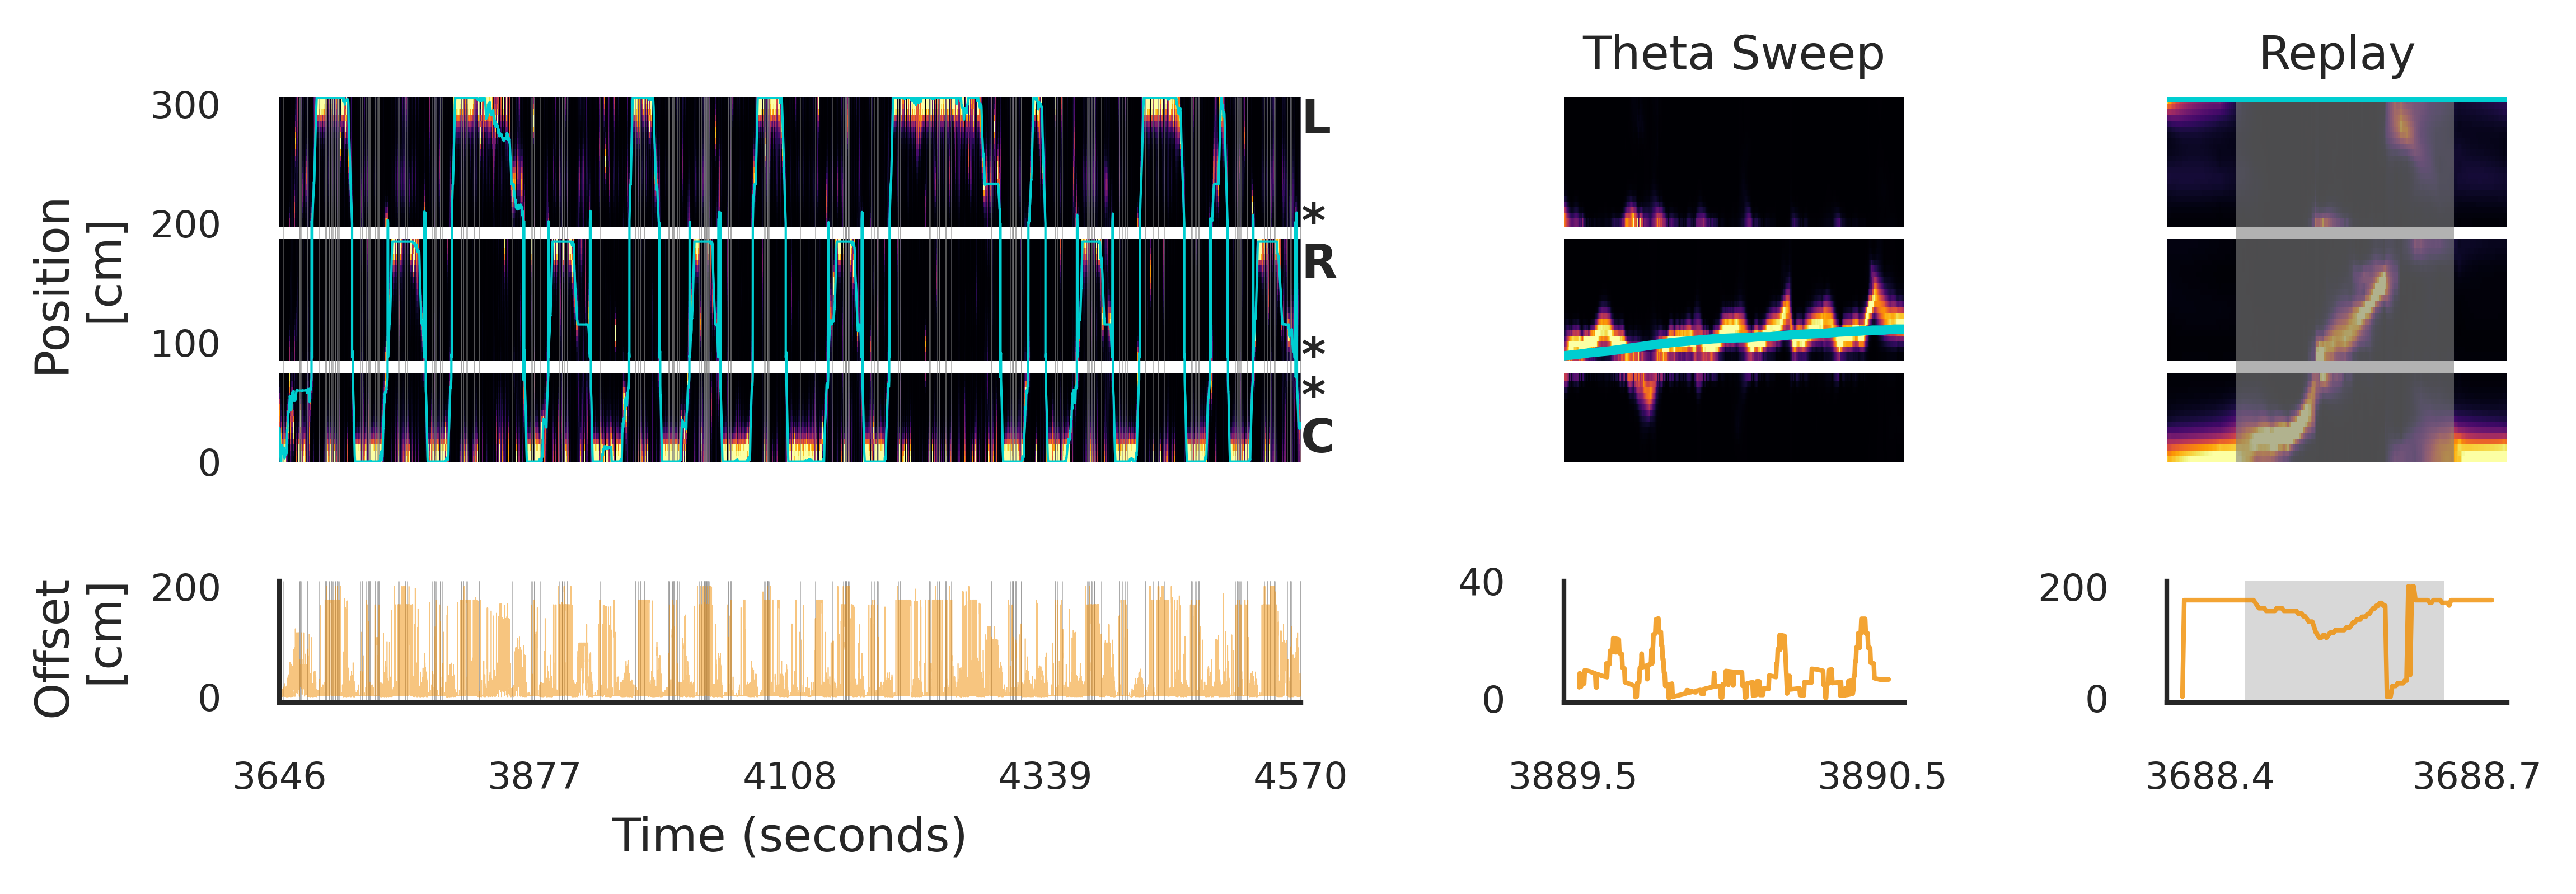

In [8]:
time_slice = slice(t.min(), t.max())  # 107-117
time_slice_replay = slice(t.min() + 42.35, t.min() + 42.7)
time_slice_sweep = slice(t.min() + 243.5, t.min() + 244.5)
plot_decoded_trajectory(
    time_slice,
    time_slice_sweep,
    time_slice_replay,
    t,
    cv_classifier_clusterless_results,
    data,
)

In [28]:
def plot_decoded_trajectory_theta_replay_examples(
    time_slice, time_slice_sweep, time_slice_replay, t, results, data
):

    """
    Modified from https://github.com/edeno/replicate_kenny_analysis/blob/master/notebooks/Bond_day8_Epoch4.ipynb
    by Zilong, 30/08/2023
    plor the theta sweeps in time_slice
    Input:
        time_slice: the time slice to plot
        t: the time index
        results: the results from the model
        data: the data from the model
        add_zero_phase_index: whether to add the zero phase index
    Output:
        a plot with 3 subplots
    """

    cmap = plt.cm.inferno
    cmap.set_bad("white", alpha=1.0)
    labelsize = 10
    ticksize = 8
    # set background color to white
    sns.set_style("white")

    fig = plt.figure(figsize=(4, 3), dpi=300)

    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[3, 1])

    # ax 3
    ax3 = plt.subplot(gs[0, 0])
    # plot
    results["acausal_posterior"].sum("state", skipna=False).sel(
        time=time_slice_sweep
    ).plot(
        x="time",
        y="position",
        robust=True,
        ax=ax3,
        cmap=cmap,
        vmin=0.0,
    )

    ax3.plot(
        data["position_info"].reset_index().set_index(t).loc[time_slice_sweep].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice_sweep]
        .linear_position,
        color="darkturquoise",
        linestyle="-",
        linewidth=2,
        alpha=1,
    )

    # remove all labels, ticks and spines in axi, as well as colorbars
    ax3.set_xlabel("")
    ax3.set_ylabel("")
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.spines["left"].set_visible(False)
    ax3.spines["bottom"].set_visible(False)
    ax3.collections[0].colorbar.remove()
    # add title
    ax3.set_title("Theta Sweep", fontsize=labelsize)

    # ax4
    ax4 = plt.subplot(gs[1, 0])
    results.mental_distance_from_actual_position.sel(time=time_slice_sweep).plot(
        x="time", ax=ax4, color="#F18D00", linewidth=1, alpha=0.8
    )
    # set y label as 'Offset' and x label empty
    ax4.set_ylabel("", fontsize=labelsize)
    ax4.set_xlabel("", fontsize=labelsize)
    # set ticks off
    ax4.set_yticks([0, 40])
    # set x ticks with time_slice_sweep.start and time_slice_sweep.stop, keep one decimal
    ax4.set_xticks(
        [np.round(time_slice_sweep.start, 1), np.round(time_slice_sweep.stop, 1)]
    )
    # tick labels without scientific notation
    ax4.ticklabel_format(useOffset=False, style="plain")
    # set tick font size as ticksize
    ax4.tick_params(labelsize=ticksize)

    # add ripple times to the plot as red bars on top of the LFP
    # first get the ripples time within the time slice
    for i in data["ripple_times"].index:
        # get the ripple time
        ripple_time = data["ripple_times"].iloc[i - 1]
        start_time = ripple_time.loc["start_time"] / np.timedelta64(1, "s")
        end_time = ripple_time.loc["end_time"] / np.timedelta64(1, "s")
        # if start_time and end_time are both in the time slice. then add the ripple to the plot
        # x range is start_time to end_time, y range is [0,300]
        if start_time > time_slice_sweep.start and end_time < time_slice_sweep.stop:
            ax3.axvspan(
                start_time, end_time, ymin=0, ymax=1, color="grey", alpha=0.6, lw=0
            )
            ax4.axvspan(
                start_time, end_time, ymin=0, ymax=1, color="grey", alpha=0.3, lw=0
            )

    # ax 5
    ax5 = plt.subplot(gs[0, 1])
    # plot
    results["acausal_posterior"].sum("state", skipna=False).sel(
        time=time_slice_replay
    ).plot(
        x="time",
        y="position",
        robust=True,
        ax=ax5,
        cmap=cmap,
        vmin=0.0,
    )

    ax5.plot(
        data["position_info"].reset_index().set_index(t).loc[time_slice_replay].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice_replay]
        .linear_position,
        color="darkturquoise",
        linestyle="-",
        linewidth=2,
        alpha=1,
    )

    # remove all labels, ticks and spines in axi, as well as colorbars
    ax5.set_xlabel("")
    ax5.set_ylabel("")
    ax5.set_yticks([])
    ax5.set_xticks([])
    ax5.spines["right"].set_visible(False)
    ax5.spines["top"].set_visible(False)
    ax5.spines["left"].set_visible(False)
    ax5.spines["bottom"].set_visible(False)
    ax5.collections[0].colorbar.remove()
    # add title
    ax5.set_title("Replay", fontsize=labelsize)

    # ax6
    ax6 = plt.subplot(gs[1, 1])
    results.mental_distance_from_actual_position.sel(time=time_slice_replay).plot(
        x="time", ax=ax6, color="#F18D00", linewidth=1, alpha=0.8
    )
    # set y label as 'Offset' and x label empty
    ax6.set_ylabel("", fontsize=labelsize)
    ax6.set_xlabel("", fontsize=labelsize)
    # set ticks off
    ax6.set_yticks([0, 200])
    # set x ticks with time_slice_replay.start and time_slice_replay.stop without scientific notation
    ax6.set_xticks(
        [np.round(time_slice_replay.start, 1), np.round(time_slice_replay.stop, 1)]
    )
    # tick labels without scientific notation
    ax6.ticklabel_format(useOffset=False, style="plain")
    # set tick font size as ticksize
    ax6.tick_params(labelsize=ticksize)

    # add ripple times to the plot as red bars on top of the LFP
    # first get the ripples time within the time slice
    for i in data["ripple_times"].index:
        # get the ripple time
        ripple_time = data["ripple_times"].iloc[i - 1]
        start_time = ripple_time.loc["start_time"] / np.timedelta64(1, "s")
        end_time = ripple_time.loc["end_time"] / np.timedelta64(1, "s")
        # if start_time and end_time are both in the time slice. then add the ripple to the plot
        # x range is start_time to end_time, y range is [0,300]
        if start_time > time_slice_replay.start and end_time < time_slice_replay.stop:
            ax5.axvspan(
                start_time, end_time, ymin=0, ymax=1, color="grey", alpha=0.6, lw=0
            )
            ax6.axvspan(
                start_time, end_time, ymin=0, ymax=1, color="grey", alpha=0.3, lw=0
            )

    # set ticks and spines
    all_axes = fig.get_axes()
    for ax in all_axes:
        ax.tick_params(labelsize=ticksize)
        ax.xaxis.label.set_size(labelsize)
        ax.yaxis.label.set_size(labelsize)
        # set axes off bottom left top and right
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # add back ax4 bottom and left spines
    ax4.spines["bottom"].set_visible(True)
    ax4.spines["left"].set_visible(True)
    # set axis linewidth 1.0
    ax4.spines["bottom"].set_linewidth(1.0)
    ax4.spines["left"].set_linewidth(1.0)

    # add back ax6 bottom and left spines
    ax6.spines["bottom"].set_visible(True)
    ax6.spines["left"].set_visible(True)
    # set axis linewidth 1.0
    ax6.spines["bottom"].set_linewidth(1.0)
    ax6.spines["left"].set_linewidth(1.0)

    plt.tight_layout()

    # save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
    savedir = (
        "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"
    )

    savename = "Fig6_decoded_trajectory_theta_replay_examples.pdf"
    plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")

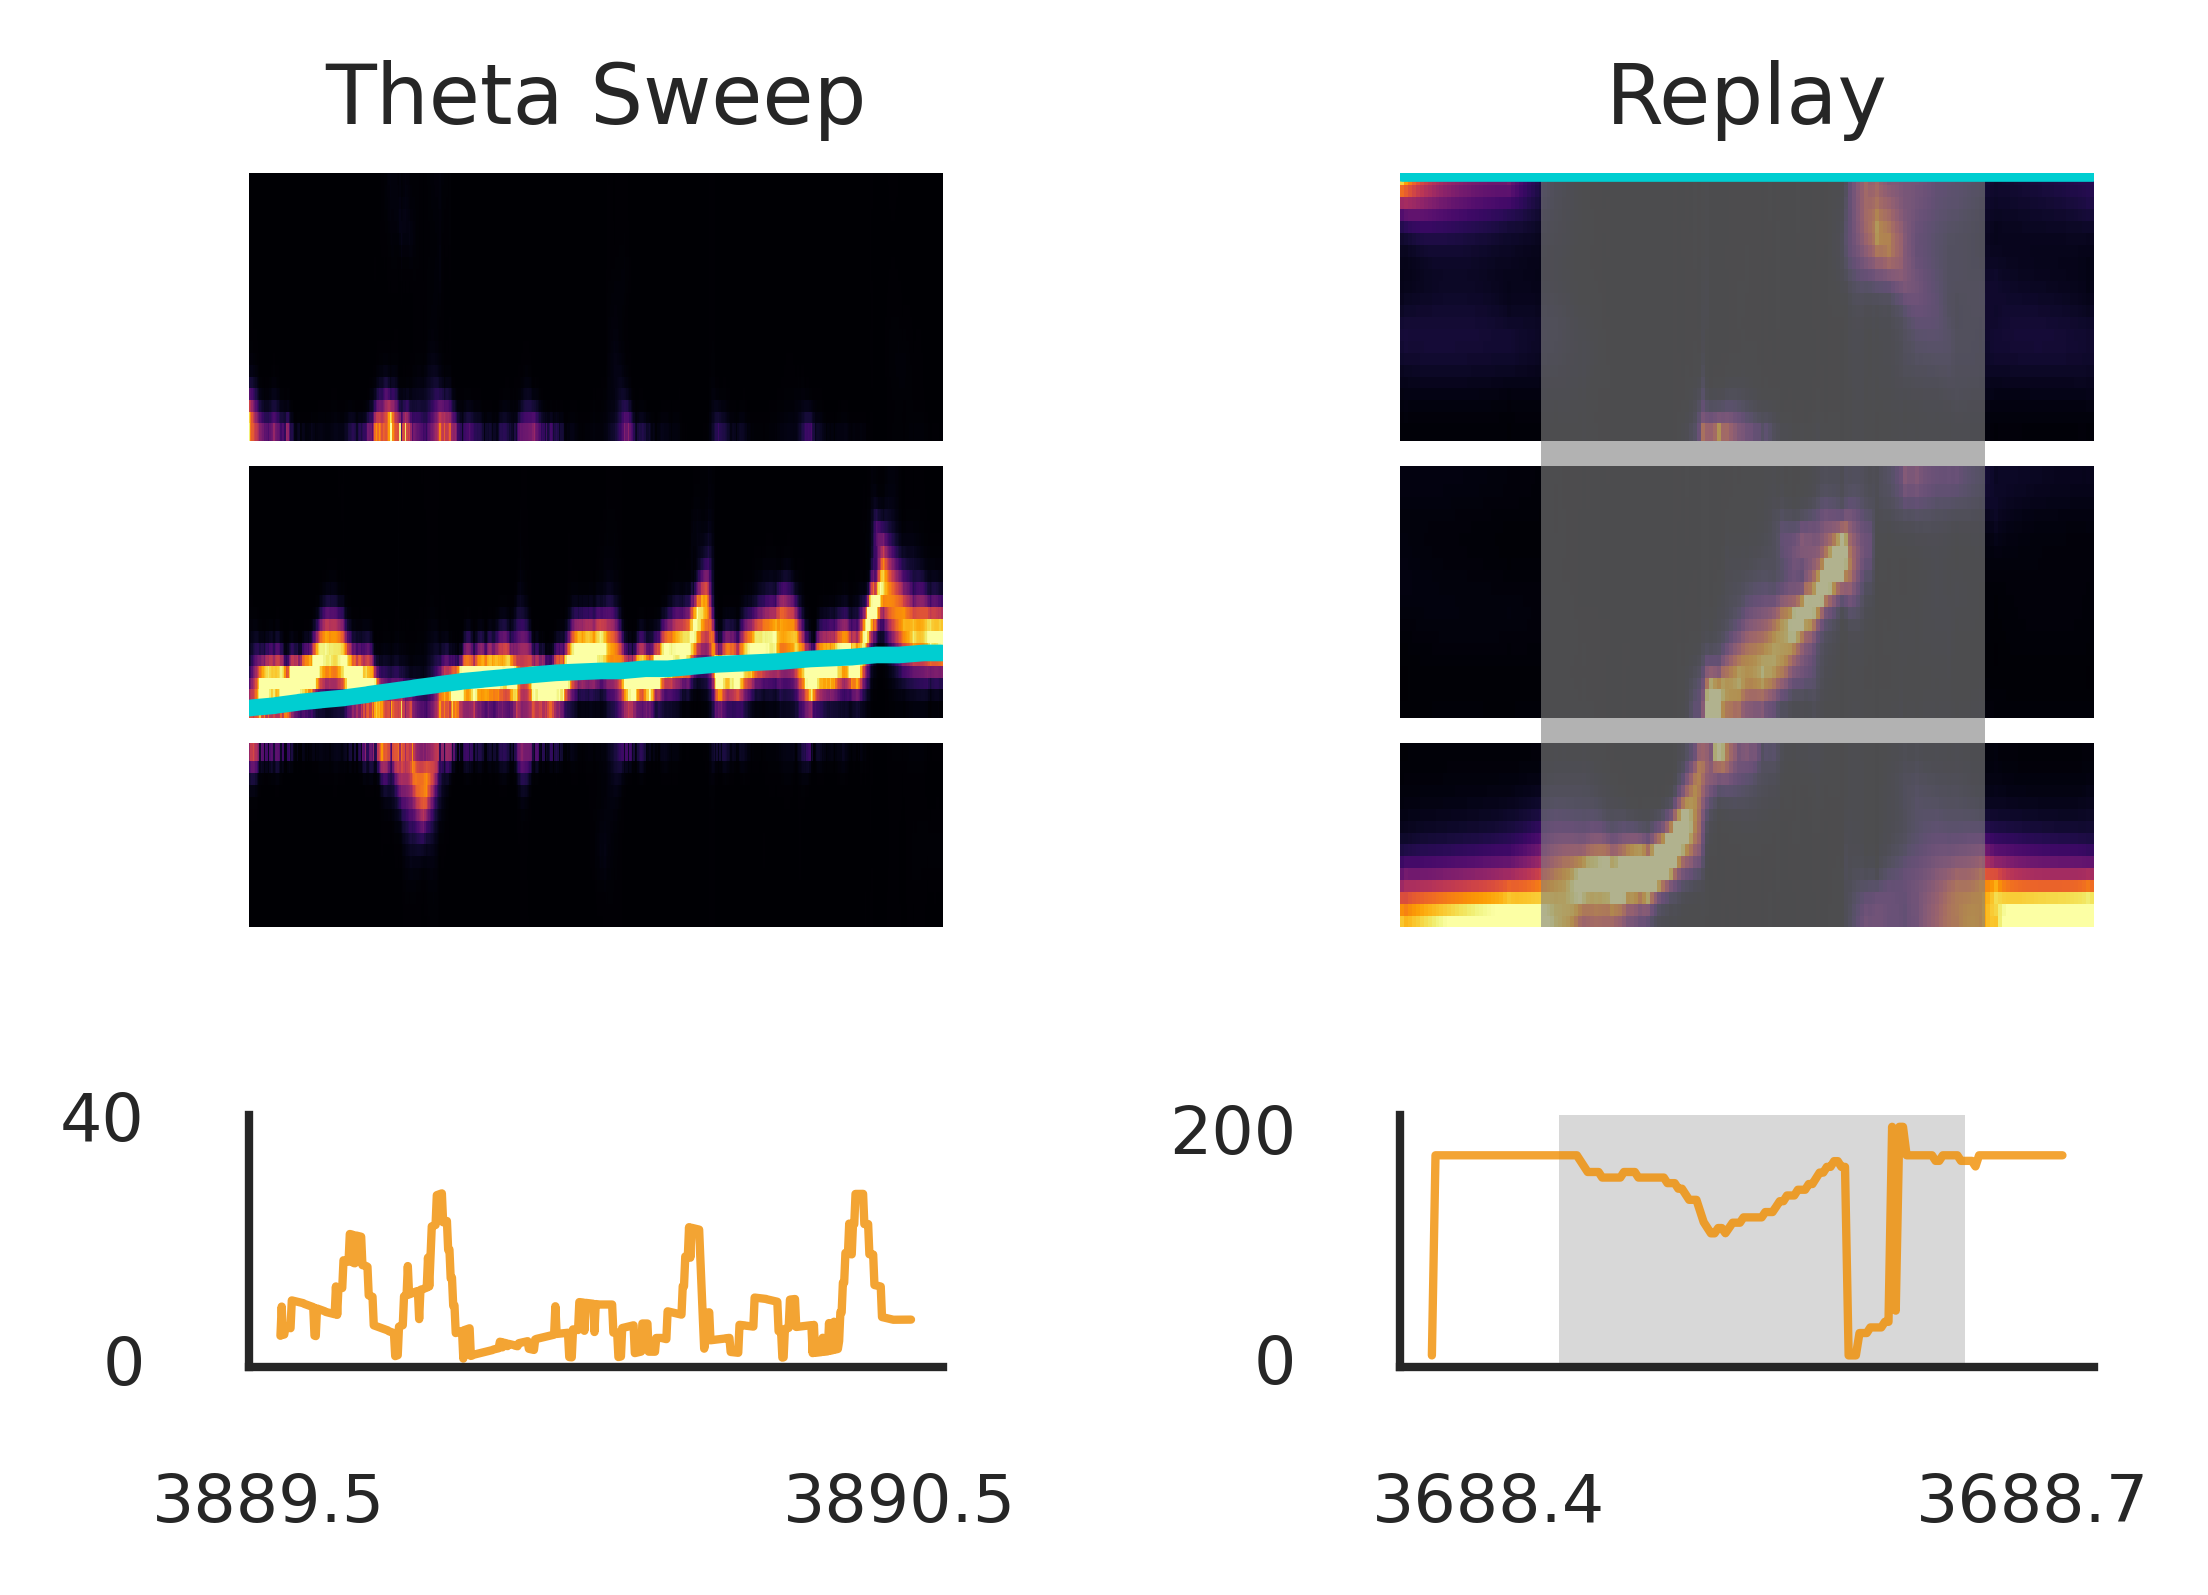

: 

In [29]:
time_slice = slice(t.min(), t.max())  # 107-117
time_slice_replay = slice(t.min() + 42.35, t.min() + 42.7)
time_slice_sweep = slice(t.min() + 243.5, t.min() + 244.5)
plot_decoded_trajectory_theta_replay_examples(
    time_slice,
    time_slice_sweep,
    time_slice_replay,
    t,
    cv_classifier_clusterless_results,
    data,
)

### 3, plot the log-log plot of step size vs. interval on the second row, as well as sweep length vs diffusion exponent from model and experimental data

In [3]:
# geneerate shuffled replay trajectories by shuffle the value under the key 'replay_trajectory'
def position_shuffling(Replay_traj):
    """
    shuffle the replay trajectory by shuffling the decoded position under each key of Replay_traj
    Input:
        Replay_traj: the replay trajectory
    Output:
        Replay_traj_shuffled: the shuffled replay trajectory
    """
    Replay_traj_shuffled = Replay_traj.copy()
    for key in Replay_traj_shuffled.keys():
        Replay_traj_shuffled[key] = np.random.permutation(Replay_traj_shuffled[key])
    return Replay_traj_shuffled

In [4]:
# load all replay trajectory from computer
replay_folder = (
    "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ReplayTrajectories"
)

# get all file with _traj.pkl
replay_files = [f for f in os.listdir(replay_folder) if f.endswith("_traj.pkl")]

# for each file, load the replay trajectory
all_exponent = []
all_exponent_shuffled = []
for replay_file in replay_files:
    # print("loading file: and calculate the diffusion exponent")
    print("load file: ", replay_file, " and calculate the diffusion exponent")
    with open(os.path.join(replay_folder, replay_file), "rb") as f:
        Replay_traj = pickle.load(f)
        exponent = get_diffusion_exponent(Replay_traj)
        all_exponent.append(exponent)

        # shuflle the replay trajectory
        Replay_traj_shuffled = position_shuffling(Replay_traj)
        exponent_shuffled = get_diffusion_exponent(Replay_traj_shuffled)
        all_exponent_shuffled.append(exponent_shuffled)

load file:  dav_07_07_traj.pkl  and calculate the diffusion exponent
load file:  bon_07_06_traj.pkl  and calculate the diffusion exponent
load file:  Cor_02_02_traj.pkl  and calculate the diffusion exponent
load file:  bon_07_02_traj.pkl  and calculate the diffusion exponent
load file:  bon_05_06_traj.pkl  and calculate the diffusion exponent
load file:  gov_08_04_traj.pkl  and calculate the diffusion exponent
load file:  dud_06_02_traj.pkl  and calculate the diffusion exponent
load file:  bon_03_02_traj.pkl  and calculate the diffusion exponent
load file:  Cor_07_02_traj.pkl  and calculate the diffusion exponent
load file:  dav_07_03_traj.pkl  and calculate the diffusion exponent
load file:  fra_04_02_traj.pkl  and calculate the diffusion exponent
load file:  gov_10_02_traj.pkl  and calculate the diffusion exponent
load file:  con_01_04_traj.pkl  and calculate the diffusion exponent
load file:  dav_04_02_traj.pkl  and calculate the diffusion exponent
load file:  con_03_02_traj.pkl  an

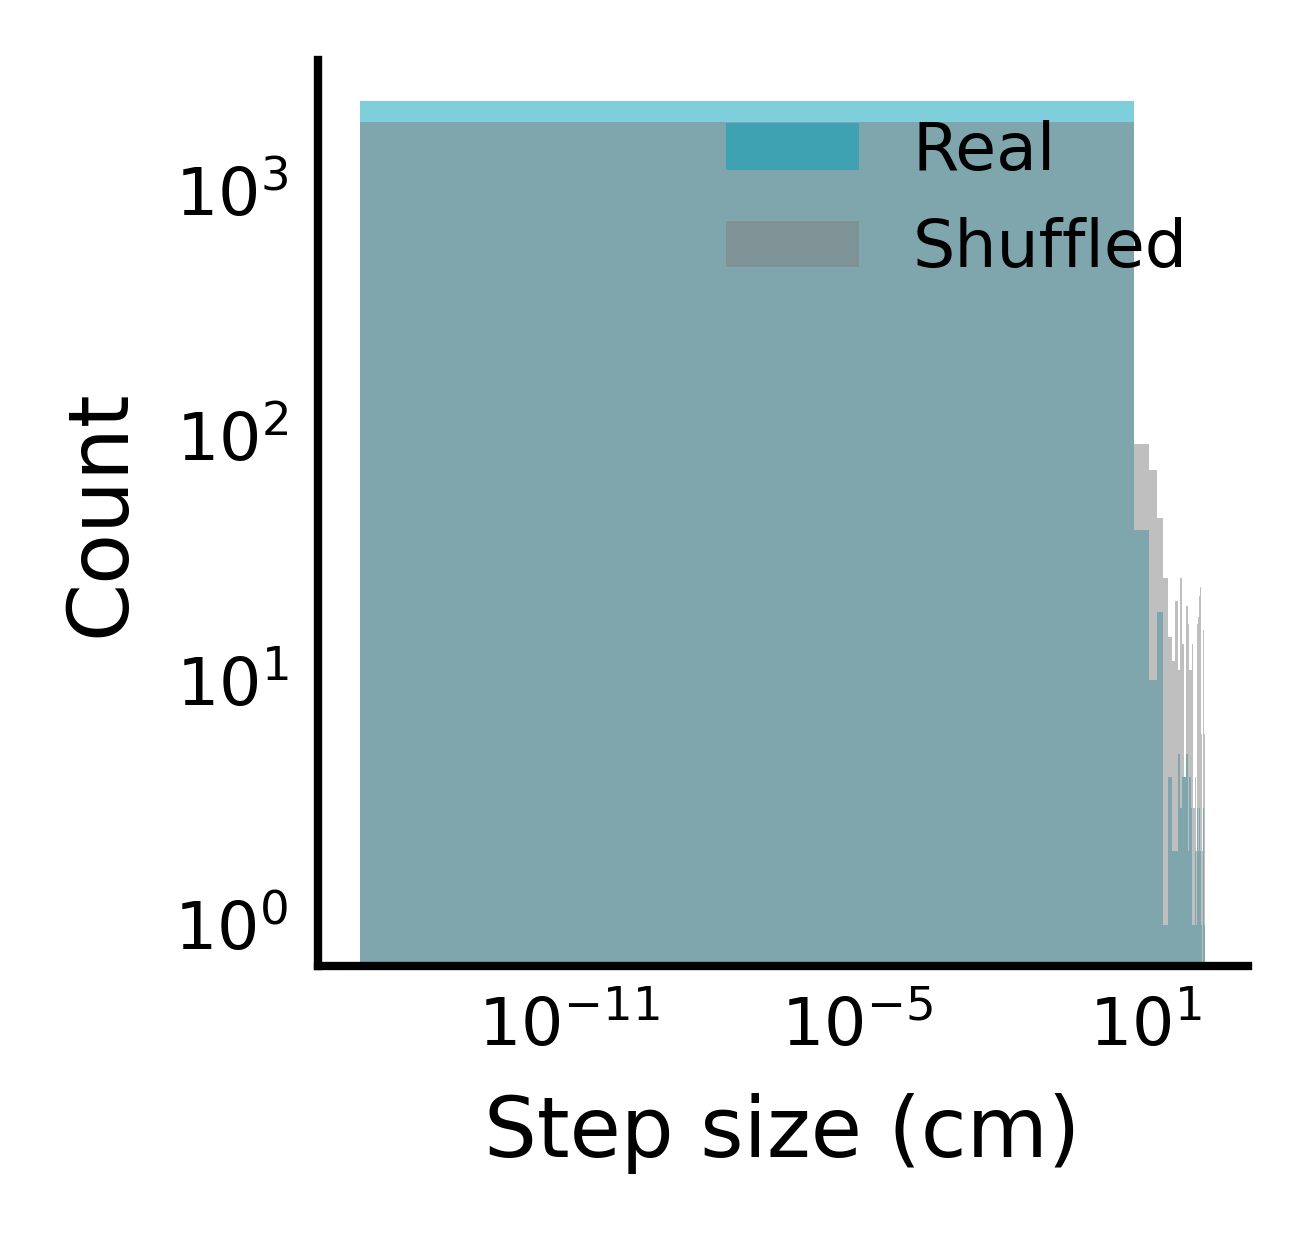

In [5]:
fig = plt.figure(figsize=(2, 2), dpi=300)
gs = gridspec.GridSpec(1, 1)
labelsize = 10
ticksize = 8
realtraj_color = "#009FB9"

# ax 1
# plot the histogram of all steps and all steps shuffled
ax0 = plt.subplot(gs[0])
all_steps = get_steps(Replay_traj, timeb=3)
# plot the histogram of all steps without edgecolor
ax0.hist(
    all_steps, bins=30, color=realtraj_color, alpha=0.5, edgecolor="none", label="Real"
)

all_steps_shuffled = get_steps(Replay_traj_shuffled, timeb=3)
# plot the histogram of all steps
ax0.hist(
    all_steps_shuffled,
    bins=30,
    color="grey",
    alpha=0.5,
    edgecolor="none",
    label="Shuffled",
)

# add legend
ax0.legend(fontsize=ticksize, loc="upper right", frameon=False)
ax0.set_xlabel("Step size (cm)", fontsize=labelsize)
ax0.set_ylabel("Count", fontsize=labelsize)
# log scale y axis and x axis
ax0.set_xscale("log")
ax0.set_yscale("log")
# ticks font size
ax0.tick_params(labelsize=ticksize)
# upper and right spine off
ax0.spines["right"].set_visible(False)
ax0.spines["top"].set_visible(False)
# axis line width 1.0
ax0.spines["bottom"].set_linewidth(1.0)
ax0.spines["left"].set_linewidth(1.0)
# tick bar off
ax0.tick_params(axis="both", which="both", length=0)

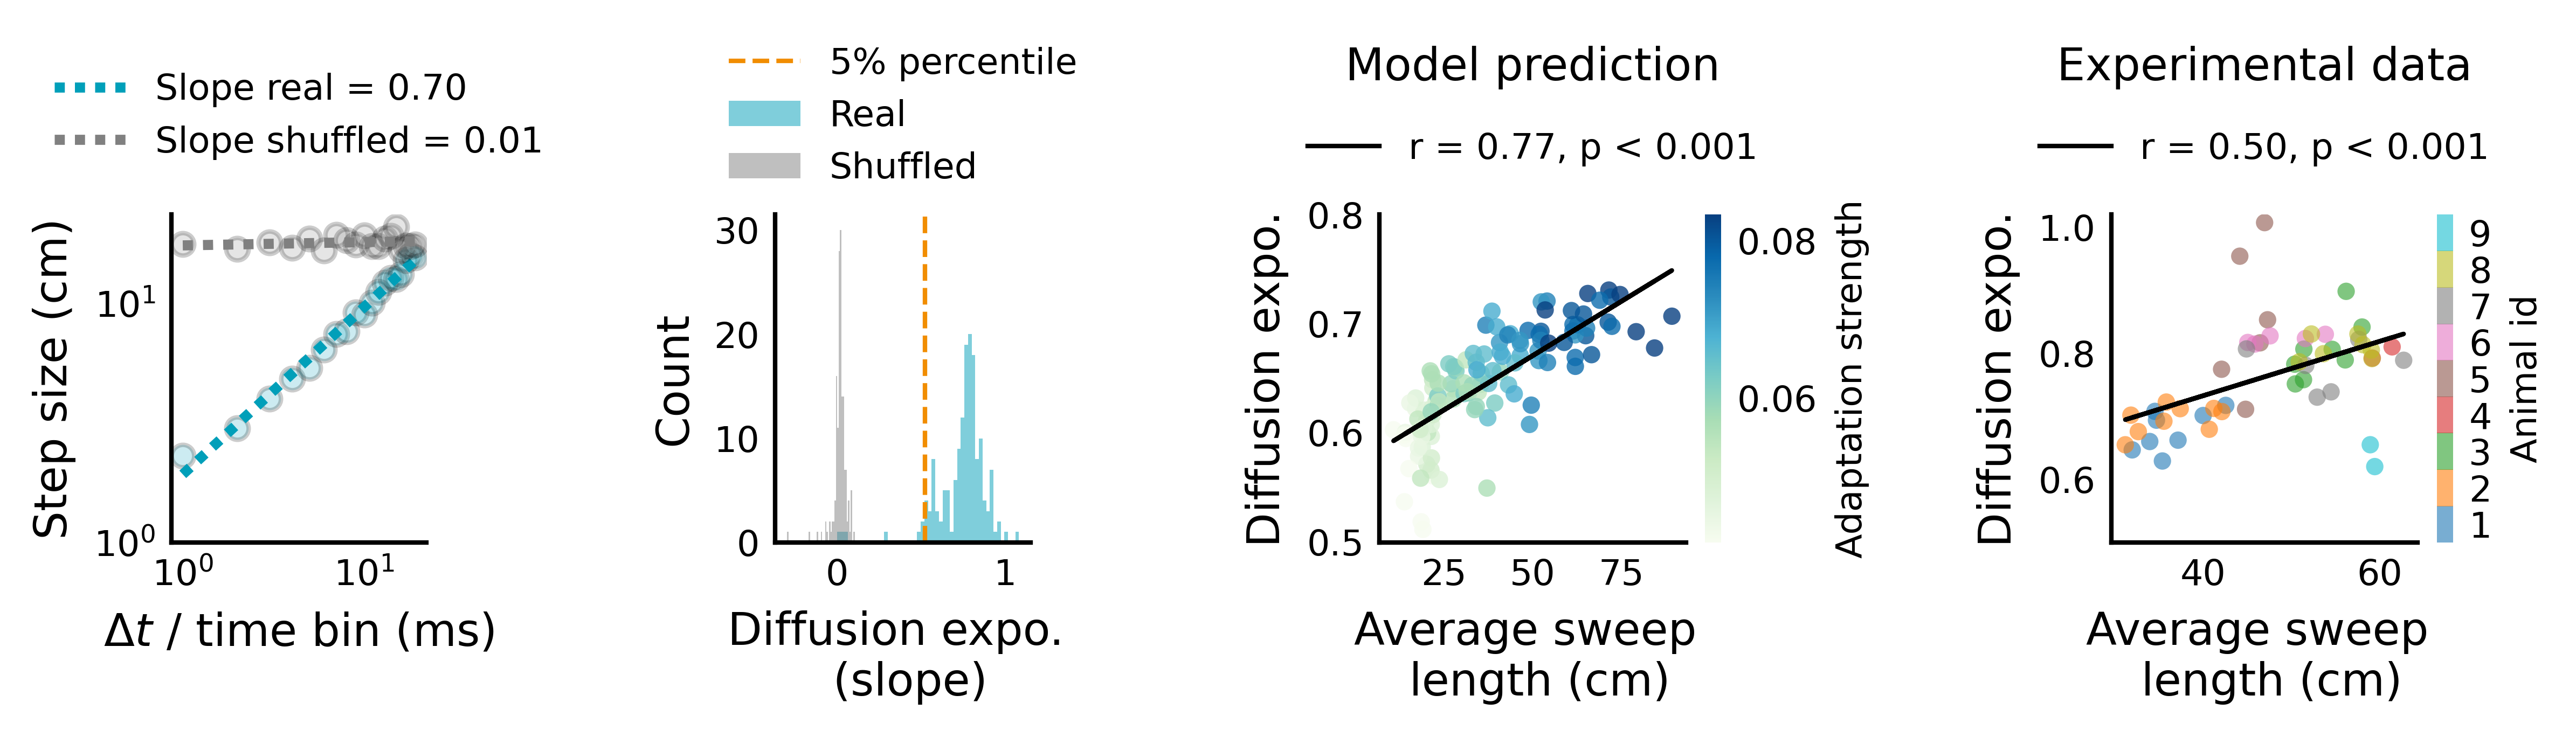

In [8]:
# load replay trajectory from the 'ReplayTrajectories'

animal, day, epoch = ("bon", 8, 4)
with open(
    os.path.join(replay_folder, f"{animal}_{day:02d}_{epoch:02d}_traj.pkl"), "rb"
) as f:
    Replay_traj = pickle.load(f)

all_timebins = np.arange(1, 20, 1)
all_avg_steps = []
for timeb in all_timebins:
    all_steps = get_steps(Replay_traj, timeb)
    # get the average step size for each time bin
    avg_step = np.mean(all_steps)
    all_avg_steps.append(avg_step)

# get the slope of the log-log plot
slope, intercept = np.polyfit(np.log(all_timebins), np.log(all_avg_steps), 1)

# get shuffled replay trajectory
Replay_traj_shuffled = position_shuffling(Replay_traj)
all_avg_steps_shuffled = []
for timeb in all_timebins:
    all_steps = get_steps(Replay_traj_shuffled, timeb)
    # get the average step size for each time bin
    avg_step = np.mean(all_steps)
    all_avg_steps_shuffled.append(avg_step)

# get the slope of the log-log plot
slope_shuffled, intercept_shuffled = np.polyfit(
    np.log(all_timebins), np.log(all_avg_steps_shuffled), 1
)


fig = plt.figure(figsize=(8.3, 3), dpi=300)
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1.5, 1.5])
labelsize = 10
ticksize = 8
realtraj_color = "#009FB9"

# ax 1
ax1 = plt.subplot(gs[0])

# plot the log-log plot and add the slope as a lagend
# marker edge color set as black with alpha 1.0
ax1.plot(
    all_timebins,
    all_avg_steps,
    "o",
    color=realtraj_color,
    markersize=5,
    alpha=0.2,
    markeredgecolor="black",
)
# add linear regression line
ax1.plot(
    all_timebins,
    np.exp(intercept) * all_timebins**slope,
    color=realtraj_color,
    linestyle=(0, (1, 1)),
    label="Slope real = %.2f" % slope,
)

# plot the shuffled replay trajectory
ax1.plot(
    all_timebins,
    all_avg_steps_shuffled,
    "o",
    color="grey",
    markersize=5,
    alpha=0.2,
    markeredgecolor="black",
)
# add linear regression line
ax1.plot(
    all_timebins,
    np.exp(intercept_shuffled) * all_timebins**slope_shuffled,
    color="grey",
    linestyle=(0, (1, 1)),
    label="Slope shuffled = %.2f" % slope_shuffled,
)

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel(r"$\Delta t$ / time bin (ms)", fontsize=labelsize)
ax1.set_ylabel("Step size (cm)", fontsize=labelsize)
# legend with box off
ax1.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.3))
# # equal aspect ratio
# ax1.set_aspect("equal")
# set both ticks to [0,10]
ax1.set_xticks([1, 10])
ax1.set_yticks([1, 10])

# ax 2
ax2 = plt.subplot(gs[1])

# plot the distribution of all_exponent and all_exponent_shuffled
ax2.hist(
    all_exponent,
    bins=50,
    color=realtraj_color,
    alpha=0.5,
    edgecolor="none",
    label="Real",
)
ax2.hist(
    all_exponent_shuffled,
    bins=50,
    color="grey",
    alpha=0.5,
    edgecolor="none",
    label="Shuffled",
)

# mark the 5% percentile of the all_exponent as a black dashed line
ax2.axvline(
    np.percentile(all_exponent, 5),
    color="#F18D00",
    linestyle="--",
    label="5% percentile",
    linewidth=1,
)
# legend
ax2.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.3))

# xlabel and ylabel
ax2.set_xlabel("Diffusion expo. \n (slope)", fontsize=labelsize)
ax2.set_ylabel("Count", fontsize=labelsize)
#

# ax 3
ax3 = plt.subplot(gs[2])

# load the data from the pickle file
import pickle

with open(
    "/home/zilong/Desktop/AdaptiveAttractorForSequences/PaperFigureCode/sweep_replay_correlation.pkl",
    "rb",
) as f:
    M, MeanSweep, MeanSweepAmp, DiffusionExp = pickle.load(f)
cmap_user = "GnBu"
# Create a colormap scalar map
norm = Normalize(vmin=np.min(M), vmax=np.max(M))
cmap = cm.get_cmap(cmap_user)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # An empty array to create the color mapping

simulation_nums = DiffusionExp.shape[0]
for i in range(simulation_nums):
    ax3.scatter(
        MeanSweepAmp[i, :],
        DiffusionExp[i, :],
        c=M,
        cmap=cmap_user,
        s=15,
        alpha=0.8,
        edgecolors="none",
    )
# add linear fit line to the plot using numpy.polyfit
# convert MeanSweep and DiffusionExp from 2D array to 1D array
exp_np = DiffusionExp.flatten()
sweep_len_np = MeanSweepAmp.flatten()
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
# pearson test
corr, p = pearsonr(sweep_len_np, exp_np)
if p < 0.001:
    ax3.plot(
        sweep_len_np,
        sweep_len_np * slope + intercept,
        "k-",
        label="r = %.2f, p < 0.001" % (corr),
        linewidth=1,
    )
else:
    ax3.plot(
        sweep_len_np,
        sweep_len_np * slope + intercept,
        "k-",
        label="r = %.2f, p = %.3f" % (corr, p),
        linewidth=1,
    )

# legend
ax3.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.2))

# Add a colorbar
cbar = plt.colorbar(sm, ax=ax3)
cbar.set_label("Adaptation strength", fontsize=ticksize)
# set colorbar box off
cbar.outline.set_visible(False)
# set colorbar ticks with fontsize ticksizes
cbar.ax.tick_params(labelsize=ticksize)

ax3.set_xlabel("Average sweep \n length (cm)", fontsize=labelsize)
ax3.set_ylabel("Diffusion expo.", fontsize=labelsize)
# ad title as 'Model prediction'
ax3.set_title("Model prediction", fontsize=labelsize, pad=30)
# change the xticks from meter to centermeter by times 100
ax3.set_xticks([0.25, 0.5, 0.75])
ax3.set_xticklabels([25, 50, 75])
# set y ticks
ax3.set_yticks([0.5, 0.6, 0.7, 0.8])

# ax4
ax4 = plt.subplot(gs[3])

# load real data: ./sweep_replay_correlation_realdata.pkl
# !!! need to run SeeepAwakeReplayCorrelation.ipynb first to generate the pickle file if not exist
with open("./sweep_replay_correlation_realdata.pkl", "rb") as f:
    (
        animal_names,
        all_sweep_len_perday_concat,
        all_sweep_amp_perday_concat,
        all_sweep_ahead_perday_concat,
        all_sweep_behind_perday_concat,
        all_exponent_perday_concat,
        all_ave_activespeed_perday_concat,
    ) = pickle.load(f)

# get the color for each animal
colors = plt.cm.get_cmap("tab10", len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)

# plot the real data
for name in animal_names:
    ax4.scatter(
        np.array(all_sweep_amp_perday_concat[name]),
        np.array(all_exponent_perday_concat[name]),
        s=15,
        alpha=0.6,
        color=color_dict[name],
        edgecolors="none",
    )

# add linear fit line to the plot using numpy.polyfit
# convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_amp_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
# pearson test
corr, p = pearsonr(sweep_len_np, exp_np)
# if p<0.001, then add label as 'r = %.2f, p < 0.001'; else add label as 'r = %.2f, p = %.3f'
if p < 0.001:
    ax4.plot(
        sweep_len_np,
        sweep_len_np * slope + intercept,
        "k-",
        label="r = %.2f, p < 0.001" % (corr),
        linewidth=1,
    )
else:
    ax4.plot(
        sweep_len_np,
        sweep_len_np * slope + intercept,
        "k-",
        label="r = %.2f, p = %.3f" % (corr, p),
        linewidth=1,
    )

# legend
ax4.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.2))


# add colorbar with alpha 0.8
cmap = ListedColormap(color_dict.values())
# Create a ScalarMappable with the colormap and normalize it
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(color_dict)))
# Set the colorbar properties
cbar = plt.colorbar(sm, ax=ax4, ticks=list(range(len(color_dict))), alpha=0.6)
# Set colorbar ticks by adding 1 to each tick
ticks = list(range(len(color_dict)))
cbar.set_ticks([tick + 0.5 for tick in ticks])
# set tick labels by adding 1 to each tick
cbar.set_ticklabels(list(range(1, len(color_dict) + 1)))
# Set colorbar ticklabels by adding 1 to each tick
# Set colorbar label
cbar.set_label("Animal id", fontsize=ticksize)
# remove the box of the colorbar
cbar.outline.set_visible(False)

ax4.set_xlabel("Average sweep \n length (cm)", fontsize=labelsize)
ax4.set_ylabel("Diffusion expo.", fontsize=labelsize)
ax4.set_title("Experimental data", fontsize=labelsize, pad=30)
ax4.set_yticks([0.6, 0.8, 1.0])
ax4.set_ylim(0.5, 1.02)

# for all axes, set upper and right spine off, axis line width 1.0
all_axes = fig.get_axes()
for ax in all_axes:
    ax.tick_params(labelsize=ticksize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # axis line width 1.0
    ax.spines["bottom"].set_linewidth(1.0)
    ax.spines["left"].set_linewidth(1.0)
    # remove the tick bars on the left and bottom
    ax.tick_params(axis="both", which="both", length=0)

plt.tight_layout()

# save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
savedir = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"

savename = "Fig6_sweep_replay_correlation_row2.pdf"
plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")

### 3-2, remember to run the control study by shuffling the epoch key in-animal and between animal

### 4, check if the diffusion exponent and sweep length are correlated with the population vector correlation index

In [79]:
# load data
epoch_key = ("bon", 8, 4)
data = load_data(epoch_key)

Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules


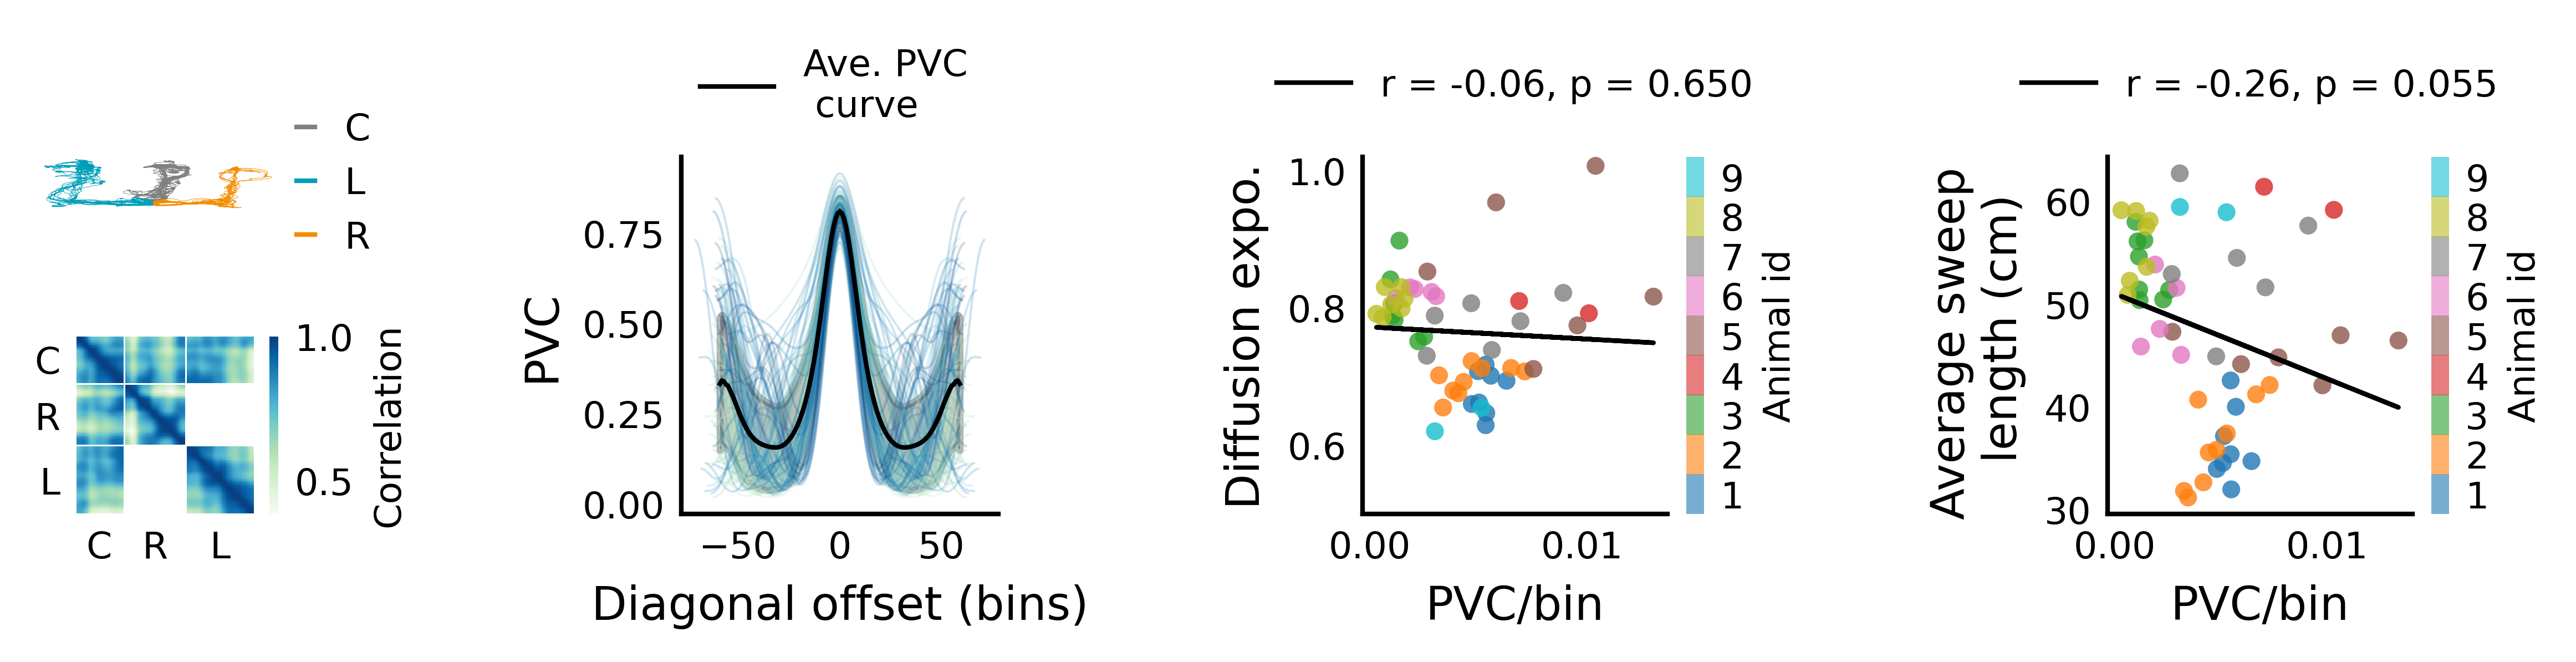

In [5]:
# !!! need to run CorrelationwithPVC.ipynb first to generate the pickle file if not exist
# './sweep_replay_correlation_with_PVC.pickle'
with open("./sweep_replay_correlation_with_PVC.pickle", "rb") as f:
    (
        all_offsets,
        all_mean_diagonal_sums,
        all_corr_matrix,
        all_unique_nan_index,
        animal_names,
        all_corrbin_perday_concat,
        all_sweep_len_perday_concat,
        all_peak_sweep_len_perday_concat,
        all_exponent_perday_concat,
    ) = pickle.load(f)

fig = plt.figure(figsize=(8.3, 2.5), dpi=300)
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1.2, 1.2], height_ratios=[0.3, 1])
labelsize = 10
ticksize = 8

# select colors equals to number of animals from a colormap
# put them in a dictionary with animal names as keys
colors = plt.cm.get_cmap("tab10", len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)

# ax0
ax0 = plt.subplot(gs[0, 0])
colors = ["grey", "#009FB9", "#F18D00"]
legends = ["C", "L", "R"]
for i, (task, df) in enumerate(data["position_info"].groupby("arm_name")):
    ax0.plot(
        df.x_position,
        df.y_position,
        color=colors[i],
        linewidth=0.1,
        label=legends[i],
    )

# axis ticks off
ax0.set_xticks([])
ax0.set_yticks([])

# add legend to the right of ax0 make the line shorter and thicker
legend = ax0.legend(
    fontsize=ticksize,
    frameon=False,
    loc="center",
    bbox_to_anchor=(1.2, 0.5),
    handlelength=0.5,
)
# Get the handles (legend lines) from the legend
handles = legend.legendHandles

# Set the linewidth of the legend lines
for handle in handles:
    handle.set_linewidth(1.0)  # Adjust the linewidth as needed

# change the x and y ratio as 2:1
ax0.set_aspect(0.2, adjustable="box")

# ax1
ax1 = plt.subplot(gs[1:, 0])
corr_matrix = all_corr_matrix[("bon", 8, 2)]
unique_nan_index = all_unique_nan_index[("bon", 8, 2)]
# imshow of the correlation matrix
# set raw: unique_nan_index[0]:unique_nan_index[1], column: unique_nan_index[1]:len(corr_matrix) as nan
# set raw: unique_nan_index[1]:len(corr_matrix), column: unique_nan_index[0]:unique_nan_index[1] as nan
corr_matrix[
    unique_nan_index[0] : unique_nan_index[1], unique_nan_index[1] : len(corr_matrix)
] = np.nan
corr_matrix[
    unique_nan_index[1] : len(corr_matrix), unique_nan_index[0] : unique_nan_index[1]
] = np.nan
ax1.imshow(corr_matrix, cmap="GnBu")
# ax1.set_xlabel("Pos. bins", fontsize=labelsize)
# ax1.set_ylabel("Pos. bins", fontsize=labelsize)

# x y ticks
ax1.set_xticks([12, 43, 79])
ax1.set_yticks([12, 43, 79])
# tick labels as 'C', 'R' ,'L'
ax1.set_xticklabels(["C", "R", "L"], fontsize=ticksize)
ax1.set_yticklabels(["C", "R", "L"], fontsize=ticksize)
# ax1.set_title("Population vector \n correlation (PVC)", fontsize=labelsize)
# make the colobar
cbar = plt.colorbar(ax1.imshow(corr_matrix, cmap="GnBu"), ax=ax1)
cbar.set_label("Correlation", fontsize=ticksize)
# set colorbar box off
cbar.outline.set_visible(False)
# set colorbar ticks with fontsize ticksizes
cbar.ax.tick_params(labelsize=ticksize)

# ax2
ax2 = plt.subplot(gs[:, 1])
# using cmap to get the color of each line
cmap = plt.get_cmap("GnBu")
# set the color cycle of the plot
plt.gca().set_prop_cycle(
    color=[cmap(i) for i in np.linspace(0, 1, len(all_offsets.keys()))]
)
# plot all mean_diagonal_sums

all_half_sum = []
for key in all_offsets.keys():
    Offsets = all_offsets[key]
    mean_diagonal_sums = all_mean_diagonal_sums[key]
    # normalize mean_diagonal_sums to 0 to 1
    mean_diagonal_sums = (mean_diagonal_sums - np.min(mean_diagonal_sums)) / (
        np.max(mean_diagonal_sums) - np.min(mean_diagonal_sums)
    )
    # Gaussian smooth the mean_diagonal_sums
    mean_diagonal_sums = gaussian_filter1d(mean_diagonal_sums, sigma=5)
    ax2.plot(Offsets, mean_diagonal_sums, alpha=0.2, linewidth=0.5)
    # keep the right half of the mean_diagonal_sums
    half_sum = mean_diagonal_sums[int(len(mean_diagonal_sums) / 2) :]
    all_half_sum.append(half_sum)

# make each elemnt in all_half_sum have the same length, pad np.nan  to the end of the shorter element
all_half_sum = np.array(all_half_sum)
# max_len = np.max([len(x) for x in all_half_sum])
max_len = 60

all_half_sum = np.array(
    [
        np.pad(x, (0, max_len - len(x)), "constant", constant_values=np.nan)
        if len(x) < max_len
        else x[:max_len]
        for x in all_half_sum
    ]
)

# take nanmean of all_half_sum along the first axis
mean_half_sum = np.nanmean(all_half_sum, axis=0)
# plot mean_half_sum
ax2.plot(
    np.arange(0, len(mean_half_sum)),
    mean_half_sum,
    label="Ave. PVC \n curve",
    linewidth=1,
    color="k",
)
# add shaded area of std to the plot
ax2.fill_between(
    np.arange(0, len(mean_half_sum)),
    mean_half_sum + np.nanstd(all_half_sum, axis=0),
    mean_half_sum - np.nanstd(all_half_sum, axis=0),
    alpha=0.3,
    color="k",
)
# plot by flipping mean_half_sum to the left side
ax2.plot(
    -np.arange(0, len(mean_half_sum)),
    mean_half_sum,
    linewidth=1,
    color="k",
)
# add shaded area of std to the plot
ax2.fill_between(
    -np.arange(0, len(mean_half_sum)),
    mean_half_sum + np.nanstd(all_half_sum, axis=0),
    mean_half_sum - np.nanstd(all_half_sum, axis=0),
    alpha=0.3,
    color="k",
)

ax2.set_xlabel("Diagonal offset (bins)", fontsize=labelsize)
ax2.set_ylabel("PVC", fontsize=labelsize)

# legend
ax2.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.2))

# ax3
ax3 = plt.subplot(gs[:, 2])

# plot all_exponent_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    ax3.scatter(
        np.array(all_corrbin_perday_concat[name]),
        np.array(all_exponent_perday_concat[name]),
        s=15,
        alpha=0.8,
        color=color_dict[name],
        edgecolors="none",
    )
# add linear fit line to the plot using numpy.polyfit
# convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
corrbin_np = np.concatenate(list(all_corrbin_perday_concat.values()))
exponent_np = np.concatenate(list(all_exponent_perday_concat.values()))
slope, intercept = np.polyfit(corrbin_np, exponent_np, 1)
# pearson test
corr, p = pearsonr(corrbin_np, exponent_np)
ax3.plot(
    corrbin_np,
    corrbin_np * slope + intercept,
    "k-",
    label="r = %.2f, p = %.3f" % (corr, p),
    linewidth=1,
)

# legend
ax3.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.2))

# add colorbar with alpha 0.8
cmap = ListedColormap(color_dict.values())
# Create a ScalarMappable with the colormap and normalize it
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(color_dict)))
# Set the colorbar properties
cbar = plt.colorbar(sm, ax=ax3, ticks=list(range(len(color_dict))), alpha=0.6)
# Set colorbar ticks by adding 1 to each tick
ticks = list(range(len(color_dict)))
cbar.set_ticks([tick + 0.5 for tick in ticks])
# set tick labels by adding 1 to each tick
cbar.set_ticklabels(list(range(1, len(color_dict) + 1)))
# Set colorbar ticklabels by adding 1 to each tick
# Set colorbar label
cbar.set_label("Animal id", fontsize=ticksize)
# remove the box of the colorbar
cbar.outline.set_visible(False)

ax3.set_xlabel("PVC/bin", fontsize=labelsize)
ax3.set_ylabel("Diffusion expo.", fontsize=labelsize)
ax3.set_ylim([0.5, 1.02])


# ax4
ax4 = plt.subplot(gs[:, 3])

# plot all_intercept_perday_concat against all_ave_speed_perday_concat
for name in animal_names:
    plt.scatter(
        np.array(all_corrbin_perday_concat[name]),
        np.array(all_peak_sweep_len_perday_concat[name]),
        s=15,
        alpha=0.8,
        color=color_dict[name],
        edgecolors="none",
    )
# add linear fit line to the plot using numpy.polyfit
# convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
corrbin_np = np.concatenate(list(all_corrbin_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_peak_sweep_len_perday_concat.values()))
slope, intercept = np.polyfit(corrbin_np, sweep_len_np, 1)
# pearson test
corr, p = pearsonr(corrbin_np, sweep_len_np)
ax4.plot(
    corrbin_np,
    corrbin_np * slope + intercept,
    "k-",
    label="r = %.2f, p = %.3f" % (corr, p),
    linewidth=1,
)

# legend
ax4.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.2))

# add colorbar with alpha 0.8
cmap = ListedColormap(color_dict.values())
# Create a ScalarMappable with the colormap and normalize it
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(color_dict)))
# Set the colorbar properties
cbar = plt.colorbar(sm, ax=ax4, ticks=list(range(len(color_dict))), alpha=0.6)
# Set colorbar ticks by adding 1 to each tick
ticks = list(range(len(color_dict)))
cbar.set_ticks([tick + 0.5 for tick in ticks])
# set tick labels by adding 1 to each tick
cbar.set_ticklabels(list(range(1, len(color_dict) + 1)))
# Set colorbar ticklabels by adding 1 to each tick
# Set colorbar label
cbar.set_label("Animal id", fontsize=ticksize)
# remove the box of the colorbar
cbar.outline.set_visible(False)

ax4.set_xlabel("PVC/bin", fontsize=labelsize)
ax4.set_ylabel("Average sweep \n length (cm)", fontsize=labelsize)
# ax4.set_ylim([0, 60])

# for all axes, set upper and right spine off, axis line width 1.0
all_axes = fig.get_axes()
for ax in all_axes:
    ax.tick_params(labelsize=ticksize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # axis line width 1.0
    ax.spines["bottom"].set_linewidth(1.0)
    ax.spines["left"].set_linewidth(1.0)
    # remove the tick bars on the left and bottom
    ax.tick_params(axis="both", which="both", length=0)

ax0.spines["left"].set_visible(False)
ax0.spines["bottom"].set_visible(False)

ax1.spines["left"].set_visible(False)
ax1.spines["bottom"].set_visible(False)

plt.tight_layout()

# save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
savedir = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"

savename = "Fig6_sweep_replay_correlation_row3.pdf"
plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")